In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Лабораторная работа №4

## Вариант 1. Задание 1.

Найти решение краевой задачи для одномерного стационарного уравнения теплопроводности:
$$ \frac{d}{dx} \left[ k(x) \frac{du}{dx} \right] - q(x)u = -f(x) $$
в одиннадцати равноудаленных точках отрезка [0, 1]

### Условие задачи

Краевые условия задачи:
$$ k(0)u_x'(0) = 0 $$
$$ -k(1)u_x'(0) = u(1) $$

$$ k(x) = e^x; q(x) = e^x; f(x) = \sin x $$

Модельная задача:
$$ k(x) = \sqrt{e}; q(x) = \sqrt{e}; f(x) = \sin 0.5 $$

In [2]:
def k(x):
    return np.exp(x)

def q(x):
    return np.exp(x)

def f(x):
    return np.sin(x)

del_1 = 0
eps_1 = 0

del_2 = 1
eps_2 = 0

# Численное решение задачи с переменными коэффициентами

In [3]:
def sweep_method(L, segment=[0, 1]):
    grid, h = np.linspace(*segment, L, retstep=True)

    # forward run
    a = [k(grid[0])]
    b = [-(k(grid[0]) + del_1*h)]
    c = [0]
    d = [-eps_1 * h]

    alpha = [-a[0] / b[0]]
    beta = [d[0] / b[0]]

    for l in range(1, L-1):
        # считаем коэффициенты a, b, c, d
        a.append(k(grid[l] + h/2))
        b.append(-(k(grid[l] + h/2) + k(grid[l] - h/2) + q(grid[l]) * h**2))
        c.append(k(grid[l] - h/2))
        d.append(-f(grid[l]) * h**2)

        # считаем коэффициенты alpha и beta
        alpha.append(-a[l] / (b[l] + c[l]*alpha[l-1]))
        beta.append((d[l] - c[l]*beta[l-1]) / (b[l] + c[l]*alpha[l-1]))

    a.append(0)
    b.append(-(k(grid[-1]) + del_2*h))
    c.append(k(grid[-1]))
    d.append(-eps_2 * h)
    
    # reverse run
    u = np.empty(L)
    u[-1] = (d[-1] - c[-1]*beta[-1]) / (b[-1] + c[-1]*alpha[-1])

    for l in range(L-2, -1, -1):
        u[l] = alpha[l] * u[l+1] + beta[l]
        
    return grid, u

# Аналитическое решение модельной задачи

In [4]:
x_test = 0.5

k_ = k(x_test)
q_ = q(x_test)
f_ = f(x_test)

lmd_1 = np.sqrt(q_ / k_)
lmd_2 = -np.sqrt(q_ / k_)

In [5]:
A1 = (k_ * lmd_2 + del_2) * (del_1 * f_ - eps_1 * q_)
A2 = (k_ * lmd_1 + del_2) * (del_1 * f_ - eps_1 * q_)
B1 = (k_ * lmd_2 - del_1) * (del_2 * f_ - eps_2 * q_)
B2 = (k_ * lmd_1 - del_1) * (del_2 * f_ - eps_2 * q_)
C = (k_ * lmd_1 - del_1) * (k_ * lmd_2 + del_2)
D = (k_ * lmd_2 - del_1) * (k_ * lmd_1 + del_2)

C_1 = (A1 * np.exp(lmd_2) + B1) / (q_ * (C * np.exp(lmd_2) - D * np.exp(lmd_1)))
C_2 = (A2 * np.exp(lmd_1) + B2) / (q_ * (-C * np.exp(lmd_2) + D * np.exp(lmd_1)))

In [6]:
def u_analytical(x):
    return C_1 * np.exp(lmd_1 * x) + C_2 * np.exp(lmd_2 * x) + f_ / q_

# Численное решение модельной задачи

In [7]:
def sweep_method_model(L):
    grid, h = np.linspace(0, 1, L, retstep=True)

    a_l = k_
    b_l = -2*k_ - q_ * h**2
    c_l = k_
    d_l = -f_ * h**2

    a_0 = k_
    b_0 = -k_ - del_1*h
    c_0 = 0
    d_0 = -eps_1*h

    a_L = 0
    b_L = -k_ - del_2*h
    c_L = k_
    d_L = -eps_2 * h

    alpha = [-a_0 / b_0]
    beta = [d_0 / b_0]

    for l in range(1, L-1):
        alpha.append(-a_l / (b_l + c_l*alpha[l-1]))
        beta.append((d_l - c_l*beta[l-1]) / (b_l + c_l*alpha[l-1]))

    u = np.empty(L)
    u[-1] = (d_L - c_L*beta[-1]) / (b_L + c_L*alpha[-1])

    for l in range(L-2, -1, -1):
        u[l] = alpha[l] * u[l+1] + beta[l]
        
    return grid, u

# Общий ответ

Расчет всех необходимых значений и вывод всех нужных графиков

In [8]:
def common_answer(L):
    grid, u = sweep_method(L)
    grid_model, u_model = sweep_method_model(L)
    u_a = u_analytical(grid_model)
    
    # Max difference between analytial and numerical solutions of model task
    max_diff = np.abs(u_model - u_a).max()
    
    step_for_output = (L - 1) // 10
    df = pd.DataFrame(
        {
            'Grid': grid[::step_for_output],
            'Model analytical': u_a[::step_for_output],
            'Model numerical': u_model[::step_for_output],
            'General answer': u[::step_for_output],
        }
    )
    print('Значения в 11 равноудаленных точках:\n')
    print(df.to_string(index=False))
    print(f'\nMax diff:\t{max_diff}\n')
    
    fig, (ax, ax_m) = plt.subplots(2, 1, figsize=(8, 12))
    ax.plot(grid, u)
    ax.set_title('General task')
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$u(x)$', fontsize=14)
    
    ax_m.plot(grid_model, u_model, '-r', label='numerical solution')
    ax_m.plot(grid_model, u_a, '--k', label='analytical solution')
    ax_m.set_title('Model task')
    ax_m.legend()
    ax_m.set_xlabel('$x$', fontsize=14)
    ax_m.set_ylabel('$u(x)$', fontsize=14)

### Сетка из 11 точек

Значения в 11 равноудаленных точках:

 Grid  Model analytical  Model numerical  General answer
  0.0          0.207243         0.199153        0.175832
  0.1          0.206825         0.199153        0.175832
  0.2          0.205566         0.198237        0.176646
  0.3          0.203455         0.196395        0.177515
  0.4          0.200470         0.193609        0.177907
  0.5          0.196581         0.189852        0.177471
  0.6          0.191748         0.185085        0.175999
  0.7          0.185925         0.179261        0.173394
  0.8          0.179052         0.172322        0.169642
  0.9          0.171061         0.164198        0.164796
  1.0          0.161872         0.154809        0.158948

Max diff:	0.008089505398372554



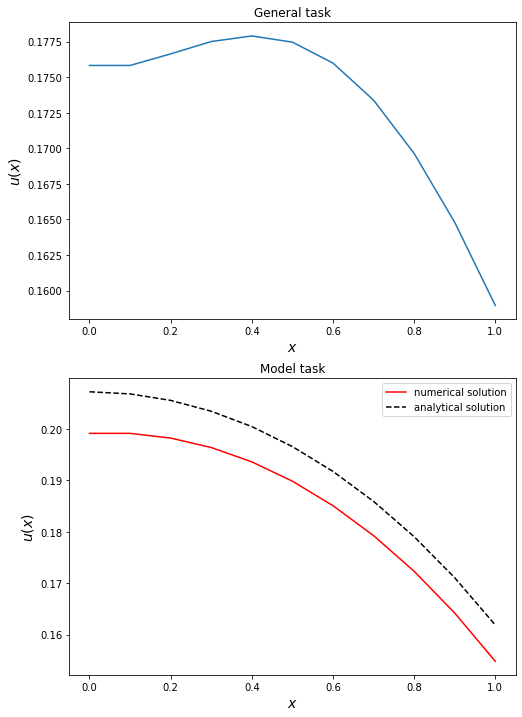

In [9]:
common_answer(L=11)

### Сетка из 10241 точки

Значения в 11 равноудаленных точках:

 Grid  Model analytical  Model numerical  General answer
  0.0          0.207243         0.207236        0.173729
  0.1          0.206825         0.206818        0.174415
  0.2          0.205566         0.205560        0.175844
  0.3          0.203455         0.203449        0.177270
  0.4          0.200470         0.200464        0.178172
  0.5          0.196581         0.196574        0.178205
  0.6          0.191748         0.191742        0.177169
  0.7          0.185925         0.185919        0.174974
  0.8          0.179052         0.179046        0.171613
  0.9          0.171061         0.171055        0.167141
  1.0          0.161872         0.161865        0.161658

Max diff:	7.342337884658212e-06



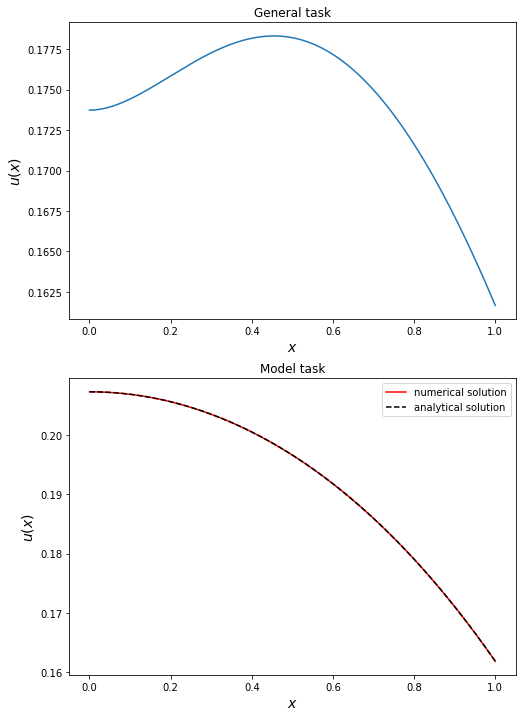

In [10]:
common_answer(L=10241)